![Header Image](../assets/header_image.png "Header Image")

# Assignment 6: Point Cloud Occupancy Grid Mapping

In this assignment, you will get in touch with a deep learning pipeline that is used to train a model, which creates occupancy grid maps from 3D lidar point clouds. In the last exercise, you have created a geometry-based algorithm that evaluates each point in a point cloud to create an occupancy grid map. In a **deep learning-based approach**, the task is not to develop the grid mapping algorithm itself but to **create a training pipeline**. This means that the **input and label data has to be loaded and prepared** and a **neural network architecture has to be chosen** so that the neural network is able to learn how to create occupancy grid maps from 3D point clouds while trained with this data.

<img src="grid_mapping/input-label.png" alt="input and label visualization" style="width: 800px;"/>

In this assignment we will walk through the following steps:

- Loading datasets for training, validating and testing the model
- Building a data pipeline including augmentation
- Creating a TensorFlow model architecture
- Training and validating the model with synthetic data and analyzing the loss with TensorBoard
- Testing the model on synthetic and real-world data and analyzing the prediction results with TensorBoard

### Dependencies
Our data pipeline uses again the [modified version of the point_pillars package](https://github.com/ika-rwth-aachen/PointPillars) to structure 3D point clouds in pillars that are then processed by the neural network. This is described in the [original PointPillars publication](https://arxiv.org/abs/1812.05784). We already installed the `point_pillars` python package and setup everything within this notebook.

### Parameters

In the beginning, we will set some parameters that will be used later.

In [2]:
batch_size = 2 
max_points_per_pillar = 100
max_pillars = 10000
number_features = 9
number_channels = 64
step_x_size = 0.16
step_y_size = 0.16
x_min = -40.96
x_max = 40.96
y_min = -28.16
y_max = 28.16
z_min = -3.0
z_max = 1.0,
min_distance = 3.0
intensity_threshold = 100
print_time = False
label_resize_x = 256
label_resize_y = 176

### Load Datasets
We will load datasets consisting of lidar point clouds (as inputs) and occupancy grid maps (as labels) using [TensorFlow Datasets](https://www.tensorflow.org/datasets). The dataset is available as ZIP archive containing point clouds stored as [PCD files](https://pointclouds.org/documentation/tutorials/pcd_file_format.html) and occupancy grid maps stored as PNG image files. The Tensorflow Dataset description ([`evilog_2021.py`](grid_mapping/evilog_2021.py)) contains instructions how these files can be downloaded and converted to [numpy arrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html), which can be processed by TensorFlow. This is done automatically, when `tfds.load()` is executed. Subsequent runs will reuse the prepared data, which speeds up the training process.

In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_datasets as tfds
import grid_mapping.evilog_2021

dataset_train = tfds.load('evilog2021/demo', split='train', data_dir="tensorflow_datasets")
dataset_valid = tfds.load('evilog2021/demo', split='valid', data_dir="tensorflow_datasets")
dataset_test = tfds.load('evilog2021/demo', split='test', data_dir="tensorflow_datasets")
dataset_real = tfds.load('evilog2021/demo', split='real', data_dir="tensorflow_datasets")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

tensorflow_datasets/downloads/extracted/TAR_GZ.rwth-aachen.sciebo.de_s_tnvuKHcIzPAA4_downloadYYsbCmYmfAb0LPqqkRsyygPnXdawtINY89k4eVIwLPw


Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tensorflow_datasets/evilog2021/demo/1.0.0.incompleteCP02UU/evilog2021-train.tfrecord*...:   0%|     …

Generating valid examples...: 0 examples [00:00, ? examples/s]

Shuffling tensorflow_datasets/evilog2021/demo/1.0.0.incompleteCP02UU/evilog2021-valid.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling tensorflow_datasets/evilog2021/demo/1.0.0.incompleteCP02UU/evilog2021-test.tfrecord*...:   0%|      …

Generating real examples...: 0 examples [00:00, ? examples/s]

Shuffling tensorflow_datasets/evilog2021/demo/1.0.0.incompleteCP02UU/evilog2021-real.tfrecord*...:   0%|      …

Dataset evilog2021 downloaded and prepared to tensorflow_datasets/evilog2021/demo/1.0.0. Subsequent calls will reuse this data.


For time reasons, we will use a small demo dataset comprising 100 training, 50 validation and 50 test samples that were created using simulation. Additionally, there are 50 real point clouds included, which were recorded with the ika's research vehicle in urban traffic. Wait until all four datasets are prepared. You can inspect the downloaded files at `tensorflow_datasets/downloads/extracted/`.

#### Task 1: Data Shape

Now have a look at the shape of one input and label sample. Can you guess how the data is structured? Complete the following code to get the `x`, `y`, and `z` coordinate of the first point in the input point cloud. Note that you can append `.numpy()` to a `tf.Tensor` to convert the tensor to a numerical value.

In [16]:
for sample in dataset_train.take(1):
    print("grid_map shape: " + str(sample["grid_map"].shape))
    print("point_cloud shape: " + str(sample["point_cloud"].shape))
    # TASK 1: Get the x, y and z coordinate (as scalar) from the first point in the point cloud

    x = sample["point_cloud"][0][0].numpy() 
    y = sample["point_cloud"][0][1].numpy()
    z = sample["point_cloud"][0][2].numpy()
    
    print("x = " + str(x) + ", y = " + str(y) + ", z = " + str(z))

grid_map shape: (512, 352, 2)
point_cloud shape: (27417, 4)
x = 18.384949, y = -8.262523, z = 5.4008617


Expected output:

```
grid_map shape: (512, 352, 2)
point_cloud shape: (27417, 4)
x = 18.384949, y = -8.262523, z = 5.4008617
```

### Build Data Pipeline

With our datasets prepared, we will now build the data pipeline that is executed during the training to feed samples into TensorFlow's optimization algorithm. At first, we create a function for data preprocessing. Here, the raw point clouds are converted to pillar tensors and the data is augmented.

#### Task 2: Data Augmentation

We want to use data augmentation to increase the diversity of the training dataset. One such augmentation method is randomly rotating input and label by the same angle. We can use a TensorFlow method to rotate the grid maps (as they are like images) but there is no method to rotate 3D point clouds. Complete the method `augmentSample` below so that the point cloud is rotated by the same angle as the grid map.

Hints: `point_cloud` has the shape `[N, 4]`, i.e. a list of points with properties `[x, y, z, intensity]`. Create a rotation matrix to rotate the point cloud in x-y-plane. The final command applies the rotation to all points of the point cloud at once (`@` is matrix multiplication).

In [18]:
!pip3 install tensorflow_addons

     |████████████████████████████████| 612 kB 6.5 MB/s eta 0:00:01


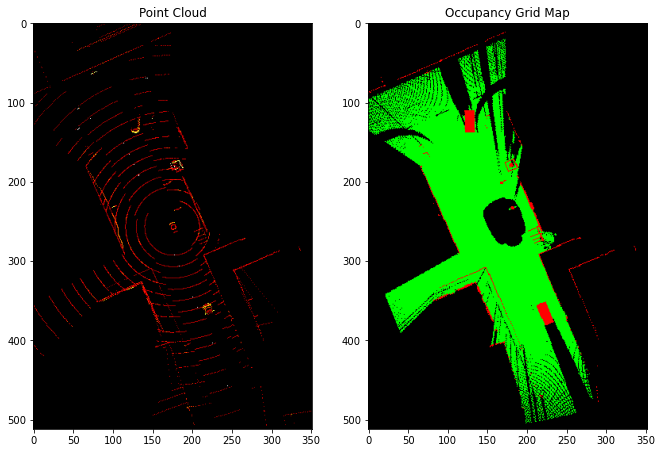

In [21]:
from point_pillars import createPillars
import random
import math
import tensorflow_addons as tfa
import numpy as np
from grid_mapping import utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from PIL import Image

%matplotlib inline

# This method augments one training sample. It is called by `preprocessSample`
def augmentSample(point_cloud, grid_map):
    angle = random.uniform(-math.pi, math.pi)
    grid_map =  tfa.image.rotate(grid_map, angle)

    # TASK 2: Create a rotation matrix that rotates the point cloud according to the grid map

    rotation_matrix = np.array([[math.cos(angle), -math.sin(angle)], 
                                  [math.sin(angle), math.cos(angle)]])
    
    point_cloud[:, 0:2] = (rotation_matrix @ point_cloud[:, 0:2].T).T

    return point_cloud, grid_map


# This method preprocesses the raw training sample before using it to optimize the model parameters
def preprocessSample(input_, label_=None):
    point_cloud = input_
    grid_map = label_
    # augment training sample (method above)
    if grid_map is not None:
      point_cloud, grid_map = augmentSample(point_cloud, grid_map)

    if intensity_threshold is not None:
            point_cloud[:, 3] = np.clip(point_cloud[:, 3] / intensity_threshold,
                                        0.0,
                                        1.0,
                                        dtype=np.float32)

    # convert list of points to tensor of pillars
    pillars, voxels = tf.numpy_function(createPillars, [point_cloud, max_points_per_pillar, max_pillars, step_x_size, step_y_size,
                                        x_min, x_max, y_min, y_max, z_min, z_max, print_time, min_distance], [np.float32, np.int32])

    # resize the grid map to the same size as the network output
    if grid_map is not None:
        grid_map = tf.image.resize(grid_map, [label_resize_x, label_resize_y], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return pillars, voxels, grid_map
    else:
        return pillars, voxels


# this wrapper allows using numpy functions in `preprocessSample``
def numpyWrapper(input_, label_=None):
    if label_ is not None:
            pillars, voxels, grid_map = tf.numpy_function(
                func=preprocessSample,
                inp=[input_, label_],
                Tout=[tf.float32, tf.int32, tf.float32])
    else:
        pillars, voxels = tf.numpy_function(func=preprocessSample,
                                            inp=[input_],
                                            Tout=[tf.float32, tf.int32])
    
    # set Tensor shapes, as tf is unable to infer rank from py_function
    # augmented lidar point is 9-dimensional
    pillars.set_shape([1, None, None, 9])
    voxels.set_shape([1, None, 3])
    if label_ is not None:
        grid_map.set_shape([None, None, 2])

    # remove batch dim from input tensors, will be added by data pipeline
    pillars = tf.squeeze(pillars, axis=0)
    voxels = tf.squeeze(voxels, axis=0)

    network_inputs = (pillars, voxels)

    if label_ is not None:
        network_labels = (grid_map)
    else:
        network_labels = None

    return network_inputs, network_labels


# Test augmentation with first sample in dataset
for sample in dataset_train.take(1):
    # augment input and label
    rotated_pointcloud, rotated_grid_map = augmentSample(sample["point_cloud"].numpy(), sample["grid_map"].numpy())
    
    # store rotated 3D point cloud as top view image
    image_point_cloud = utils.lidar_to_bird_view_img(rotated_pointcloud, x_min, x_max, y_min, y_max, step_x_size, step_y_size, intensity_threshold)
    im = Image.fromarray(image_point_cloud)
    im.save('grid_mapping/point_cloud.png')

    # store rotated occupancy grid map as image
    image_grid_map = utils.grid_map_to_img(rotated_grid_map)
    im = Image.fromarray(image_grid_map.numpy())
    im.save('grid_mapping/grid_map.png')

    # display images below
    rcParams['figure.figsize'] = 11,8
    img_A = mpimg.imread('grid_mapping/point_cloud.png')
    img_B = mpimg.imread('grid_mapping/grid_map.png')
    fig, ax = plt.subplots(1,2)
    ax[0].set_title("Point Cloud")
    ax[0].imshow(img_A);
    ax[1].set_title("Occupancy Grid Map")
    ax[1].imshow(img_B);

We will now build the data pipelines for the training and validation dataset. Each sample in the dataset consists of a point cloud and a grid map. The dataset is shuffled in training epoch and all samples are preprocessed using the `preprocessSample()` method above. Then, batches of multiple samples are created. Each batch will be used sequentially during the training in TensorFlow's optimization algorithm to improve the network parameters.

In [22]:
datapipe_train = dataset_train.map(lambda ex: (ex["point_cloud"], ex["grid_map"]))
datapipe_train = datapipe_train.shuffle(buffer_size= len(dataset_train), reshuffle_each_iteration = True)
datapipe_train = datapipe_train.map(numpyWrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
datapipe_train = datapipe_train.batch(batch_size, drop_remainder = True)
datapipe_train = datapipe_train.prefetch(tf.data.experimental.AUTOTUNE)

datapipe_valid = dataset_valid.map(lambda ex: (ex["point_cloud"], ex["grid_map"]))
datapipe_valid = datapipe_valid.shuffle(buffer_size= len(dataset_valid), reshuffle_each_iteration = True)
datapipe_valid = datapipe_valid.map(numpyWrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
datapipe_valid = datapipe_valid.batch(batch_size, drop_remainder = True)
datapipe_valid = datapipe_valid.prefetch(tf.data.experimental.AUTOTUNE)

datapipe_test_syn = dataset_test.map(lambda ex: (ex["point_cloud"],))
datapipe_test_syn_raw = datapipe_test_syn.batch(1, drop_remainder = True)
datapipe_test_syn = datapipe_test_syn.map(numpyWrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
datapipe_test_syn = datapipe_test_syn.batch(1, drop_remainder = True)

datapipe_test_real = dataset_real.map(lambda ex: (ex["point_cloud"],))
datapipe_test_real_raw = datapipe_test_real.batch(1, drop_remainder = True)
datapipe_test_real = datapipe_test_real.map(numpyWrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
datapipe_test_real = datapipe_test_real.batch(1, drop_remainder = True)

### Build Network Architecture
We need to define how the neural network is structured, e.g. how many layers, which kernel sizes, whether there are skip connections etc. As there is no perfect recipe for finding the best network architecture, we base our work on an architecutre that performs very well on a similar task, i.e. 3D lidar object detection. Thus we use a slightly modified version of PointPillar's Feature Net and CNN backbone. Have a look at the file [`point_pillars.py`](grid_mapping/point_pillars.py) to see our modifications.

#### Task 3: Evidential Prediction Head

As we do not want the model to predict 3D bounding boxes but occupancy grid maps, we removed the original preidction heads and replaced it with an "Evidential Prediction Head". This is just another 2D convolutional layer, which calculates a tensor with the same dimensions as the grid map to be predicted. It has 2 filters, hence two values are calculated for each cell (i.e. evidence for the cell being free and evidence for the cell being occupied). The predicted evidence shall be in the range $ ( 0, \inf ) $. Which activation function should be used? Set the parameter in the following code snippet.

In [23]:
from grid_mapping.point_pillars import getPointPillarsModel

# Model architecture
def getModel():
    Xn = int((x_max - x_min) / step_x_size)
    Yn = int((y_max - y_min) / step_y_size)

    # Point Pillars Feature Net and CNN backbone
    input_pillars, input_indices, output = getPointPillarsModel(
        tuple([Xn, Yn]), int(max_pillars),
        int(max_points_per_pillar), int(number_features),
        int(number_channels))

    # Evidential Prediction Head
    # TASK 3: Set the correct activation function

    prediction = tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3),
                                        padding="same",
                                        name="ogm/conv2d",
                                        activation="relu")(output)

    return tf.keras.models.Model([input_pillars, input_indices],
                                 [prediction])

TensorFlow's optimization algorithm requires a **loss function** to calculate how well the network's prediction fits the label. The training goal is to minimize this loss function. We use a custom loss function which calculates Kullback-Leiber divergence between predictions and labels. Have a look at [this publication](https://ieeexplore.ieee.org/document/9575715) if you are interested in the mathematics behind it.

In [24]:
# The neural network predicts evidences for the cell being free or occupied in the range [0, inf].
# This method converts evidences into belief masses and an uncertainty value in the range [0, 1]  
def evidences_to_masses(logits):
    # convert evidences to parameters of a Dirichlet distribution
    alpha = logits + tf.ones(tf.shape(logits))

    # Dirichlet strength (sum alpha for all classes)
    S = tf.reduce_sum(alpha, axis=-1, keepdims=True)

    num_classes = tf.cast(tf.shape(logits)[-1], tf.dtypes.float32)

    # uncertainty
    u = num_classes / S
    # belief masses
    prob = logits / S

    return prob, u, S, num_classes


class ExpectedMeanSquaredError(tf.keras.losses.Loss):

    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.epoch_num = tf.Variable(0.0)

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor):

        prob, _, S, num_evidential_classes = evidences_to_masses(y_pred)

        loss = tf.math.add(
            tf.reduce_sum((y_true - prob)**2, axis=-1, keepdims=True),
            tf.reduce_sum(prob * (1 - prob) / (S + 1), axis=-1, keepdims=True))
        alpha = y_pred * (1 - y_true) + 1
        KL_reg = tf.minimum(1.0, tf.cast(self.epoch_num / 10,
                                         tf.float32)) * self.kl_regularization(
                                             alpha, num_evidential_classes)
        loss = loss + KL_reg

        # higher weight for loss on evidence for state "occupied" because it is underrepresented in training data
        weight_occupied = 100
        loss = tf.where(y_true[..., 1] > 0.5,
                        tf.squeeze(loss * weight_occupied, axis=-1),
                        tf.squeeze(loss, axis=-1))
        loss = tf.reduce_mean(loss)

        return loss

    def kl_regularization(self, alpha, K):
        beta = tf.ones_like(alpha)
        S_alpha = tf.reduce_sum(alpha, axis=-1, keepdims=True)
        KL = tf.math.add_n([
            tf.reduce_sum((alpha - beta) *
                          (tf.math.digamma(alpha) - tf.math.digamma(S_alpha)),
                          axis=-1,
                          keepdims=True),
            tf.math.lgamma(S_alpha) -
            tf.reduce_sum(tf.math.lgamma(alpha), axis=-1, keepdims=True),
            tf.reduce_sum(tf.math.lgamma(beta), axis=-1, keepdims=True) -
            tf.math.lgamma(tf.reduce_sum(beta, axis=-1, keepdims=True))
        ])
        return KL

Having the network architecture and loss function defined, we can now compile the TensorFlow model.

In [25]:
model = getModel()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ExpectedMeanSquaredError())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pillars/input (InputLayer)     [(None, 10000, 100,  0           []                               
                                 9)]                                                              
                                                                                                  
 pillars/conv2d (Conv2D)        (None, 10000, 100,   576         ['pillars/input[0][0]']          
                                64)                                                               
                                                                                                  
 pillars/batchnorm (BatchNormal  (None, 10000, 100,   256        ['pillars/conv2d[0][0]']         
 ization)                       64)                                                           

Expected output:

```
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
pillars/input (InputLayer)      [(None, 10000, 100,  0                                            
__________________________________________________________________________________________________
pillars/conv2d (Conv2D)         (None, 10000, 100, 6 576         pillars/input[0][0]              
__________________________________________________________________________________________________
pillars/batchnorm (BatchNormali (None, 10000, 100, 6 256         pillars/conv2d[0][0]             
__________________________________________________________________________________________________
pillars/indices (InputLayer)    [(None, 10000, 3)]   0                                            
__________________________________________________________________________________________________
pillars/relu (Activation)       (None, 10000, 100, 6 0           pillars/batchnorm[0][0]          
__________________________________________________________________________________________________
...
__________________________________________________________________________________________________
cnn/up3/bn (BatchNormalization) (None, 256, 176, 128 512         cnn/up3/conv2dt[0][0]            
__________________________________________________________________________________________________
cnn/concatenate (Concatenate)   (None, 256, 176, 384 0           cnn/up1/bn[0][0]                 
                                                                 cnn/up2/bn[0][0]                 
                                                                 cnn/up3/bn[0][0]                 
__________________________________________________________________________________________________
ogm/conv2d (Conv2D)             (None, 256, 176, 2)  6914        cnn/concatenate[0][0]            
==================================================================================================
Total params: 4,741,058
Trainable params: 4,735,042
Non-trainable params: 6,016
__________________________________________________________________________________________________

```

### Train the Model
We will train the model for 5 epochs, i.e. the model sees every training sample 5 times during training. We add two callbacks that are executed regularly during the training. 

- The `tensorboard_callback` will write down the current training loss after each optmization step (i.e. after each batch). Additionally, training and validation loss will be calculated after each epoch. Both graphs are visualized in the TensorBoard window below. 
- The `model_checkpoint_callback` will save the current state of the trained model parameters (weights) after each epoch to a HDF5 file. 

In [ ]:
!rm -rf tensorboard/
!rm -rf grid_mapping/checkpoints
!mkdir -p grid_mapping/checkpoints

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='tensorboard',
    update_freq='batch',
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='grid_mapping/checkpoints/weights.{epoch:02d}.hdf5',
    save_weights_only=True)

model.fit(datapipe_train,
          validation_data=datapipe_valid,
          epochs=5,
          callbacks=[tensorboard_callback, model_checkpoint_callback])

As the training is performed using the CPU (and not the GPU) on the jupyter server, this will take a while. So get a coffee and **analyze how the training and validation error develops during the training process** using TensorBoard. To open TensorBoard, navigate to the folder `acdc/section_3_sensor_data_processing/tensorboard` in the file browser, click the blue "plus" button and select "TensorBoard". Select the **"Scalars" tab in TensorBoard** to see the the loss graphs. It may take a while until the tab appears next to the "Graphs" tab.

<img src="grid_mapping/start-tensorboard.png" alt="start tensorboard" style="width: 800px;"/>

### Test the Model on Synthetic Data
We will now use the previously trained model to create occupancy grid maps from real-world lidar point clouds.

#### Task 4: Model Selection

Have a look at the graph of the epochs' training and validation error. **The weights of which epoch should we take?** Add the missing epoch number to the filename below.

In [ ]:
!rm -rf tensorboard/images_synthetic

from tqdm import tqdm

# TASK 4: Replace XX with the 2-digit epoch number of the saved model you want to use
### START CODE HERE ###
model.load_weights('grid_mapping/checkpoints/weights.XX.hdf5')
### END CODE HERE ###

i = 0
for sample, sample_raw in zip(tqdm(datapipe_test_syn), datapipe_test_syn_raw):
  point_cloud_batch = sample[0]  # get first input batch from the traning pipeline (after `preprocessSample`)
  point_cloud_raw = sample_raw[0][0]  # get first input point cloud directly from the dataset (without preprocessing)

  # use trained model to predict grid map
  prediction_batch = model(point_cloud_batch, training=False)
  grid_map = prediction_batch[0]  # get first predicted grid map from batch

  # convert predicted evidences to belief masses
  prob, u, S, num_classes = evidences_to_masses(grid_map)

  # convert point cloud and grid map to images
  image_point_cloud = utils.lidar_to_bird_view_img(point_cloud_raw.numpy(), x_min, x_max, y_min, y_max, step_x_size, step_y_size, intensity_threshold)
  image_grid_map = utils.grid_map_to_img(prob)

  # display input and prediction in TensorBoard
  w = tf.summary.create_file_writer('tensorboard/images_synthetic2')
  with w.as_default():
    tf.summary.image("synthetic_input", [tf.cast(image_point_cloud, dtype=tf.float64)/255.0], step=i)
    tf.summary.image("synthetic_prediction", [image_grid_map], step=i)
  i = i + 1


Select the **"Images" tab in TensorBoard** to see the predicted occupancy grid maps. It may take a while until the tab appears. Use the slider above the image to switch between different test samples.
Analyze the perfomance of the trained model. Are the predicted occupancy grid maps helpful for an automated driving function? Can you explain the results?

### Test a Pretrained Model on Real-World Data

We have added a model that was trained on a dataset of 10.000 samples for 100 epochs and will use this now to predict occupancy grid maps from real-world lidar point clouds. You can see the results also in the **"Images" tab in TensorBoard**. Can you imagine how these occupancy grid maps can be useful for automated driving?

In [ ]:
!rm -rf tensorboard/images_real

model.load_weights('grid_mapping/weights.99.hdf5')

i = 0
for sample, sample_raw in zip(tqdm(datapipe_test_real), datapipe_test_real_raw):
  point_cloud_batch = sample[0]
  point_cloud_raw = sample_raw[0][0]

  # use trained model to predict grid map
  prediction_batch = model(point_cloud_batch, training=False)
  grid_map = prediction_batch[0]
  
  # convert predicted evidences to belief masses
  prob, u, S, num_classes = evidences_to_masses(grid_map)
  
  # convert point cloud and grid map to images
  image_point_cloud = utils.lidar_to_bird_view_img(point_cloud_raw.numpy(), x_min, x_max, y_min, y_max, step_x_size, step_y_size, intensity_threshold)
  image_grid_map = utils.grid_map_to_img(prob)
    
  # display input and prediction in TensorBoard
  w = tf.summary.create_file_writer('tensorboard/images_real')
  with w.as_default():
    tf.summary.image("real_input", [tf.cast(image_point_cloud, dtype=tf.float64)/255.0], step=i)
    tf.summary.image("real_prediction", [image_grid_map], step=i)
  i = i + 1

### Wrap Up

In this notebook, you learned how to

- load different datasets using the *TensorFlow Datasets* (tfds) API,
- build a data pipline including augmentation for the task of occupancy grid mapping,
- adapt the PointPillars network architecture to the new task of occupancy grid mapping,
- train and evaluate the model's performance on synthetic and on real-world data.

## References

## License

MIT License

Copyright 2023 Institute for Automotive Engineering of RWTH Aachen University.